In [1]:
import copy
import random
from types import SimpleNamespace
from typing import List
import pandas as pd
import vrplib

from tqdm import tqdm
import time
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as rnd

from alns import ALNS
from alns.accept import RecordToRecordTravel
from alns.select import *
from alns.stop import MaxIterations

from myvrplib import plot_solution, plot_data, verify_time_windows, LOGGING_LEVEL
from data_module import data, END_OF_DAY
from route import Route
from vrpstates import CvrptwState
from initial_solutions.initial_solutions import nearest_neighbor_tw
from operators.destroy import *
from operators.repair import *
from operators.wang_operators import *

Reading data from file:  pr01
Problem type:  MDVRPTW
Number of vehicles:  2
Number of customers:  48
Number of days/depots/vehicle types:  4


In [2]:
%matplotlib inline
SEED = 1234
from myvrplib import END_OF_DAY

DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.


In [3]:
import logging
logger = logging.getLogger(__name__)
logging.basicConfig(level=LOGGING_LEVEL)

# Implementation of wang 2024
https://www.sciencedirect.com/science/article/pii/S0360835224002432?via%3Dihub

NOTE: data['dimension'] is the number of customers only, not including depots

DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/pettepiero/tirocinio/.venv/lib/python3.12/site-packages/matplotlib/mpl-data/fonts/ttf/STIXNonUniIta.ttf', name='STIXNonUnicode', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/pettepiero/tirocinio/.venv/lib/python3.12/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizTwoSymBol.ttf', name='STIXSizeTwoSym', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/pettepiero/tirocinio/.venv/lib/python3.12/site-packages/matplotlib/mpl-data/fonts/ttf/cmtt10.ttf', name='cmtt10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.f

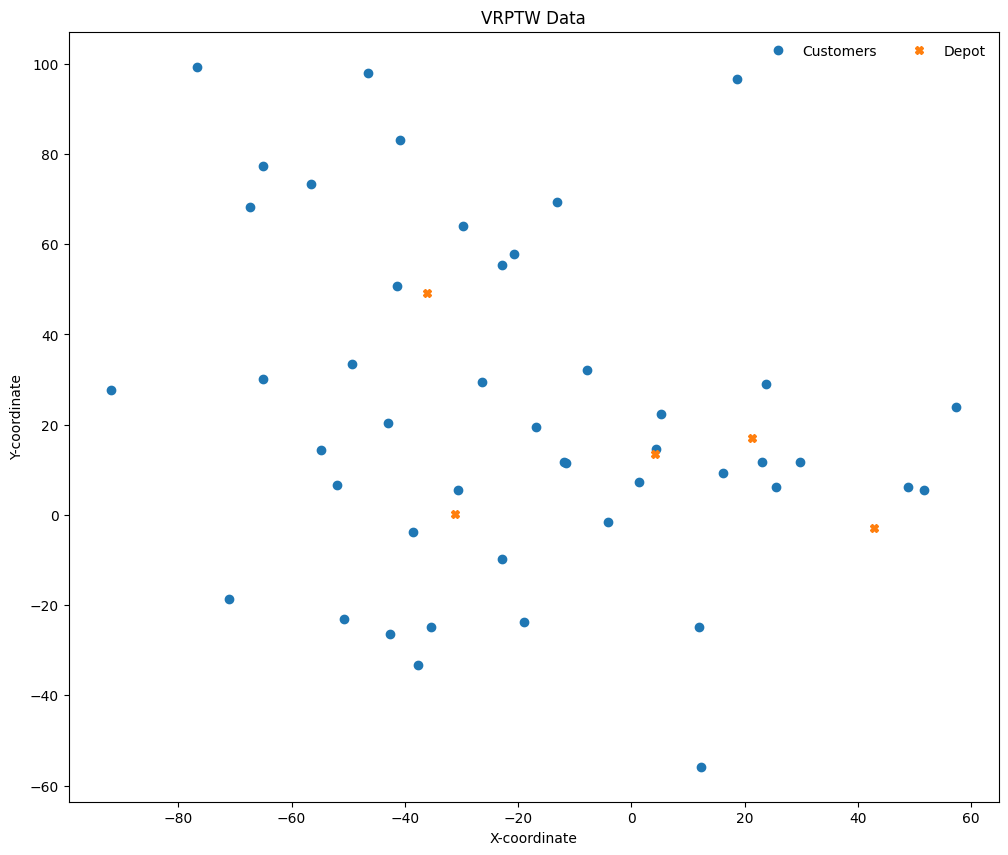

In [4]:
plot_data(data)

In [5]:
data.keys()

dict_keys(['name', 'vehicles', 'capacity', 'dimension', 'n_depots', 'depot_to_vehicles', 'vehicle_to_depot', 'depots', 'node_coord', 'demand', 'time_window', 'service_time', 'edge_weight'])

In [6]:
print(data["dimension"])
print(len(data["node_coord"]))
print(len(data["demand"]))
print(len(data["time_window"]))
print(len(data["service_time"]))
print(data["capacity"])
print(data["edge_weight"].shape)

48
53
53
53
53
200
(53, 53)


## Solution state

In [7]:
def get_customer_info(data, state: CvrptwState, idx: int, cordeau: bool = False):
    """
    Get the customer information for the passed-in index.
    """
    if cordeau:
        if idx == 0:
            print("Error: in Cordeau notation index 0 is a fake customer")
            return
        
    route = state.find_route(idx)
    if route is not None:
        index_in_route = state.find_index_in_route(idx, route)
        route_index = state.routes.index(route)
        print(f"index_in_route: {index_in_route}")
        print(f"route: {route}")

        dict = {
            "index": idx,
            "coords": data["node_coord"][idx],
            "demand": data["demand"][idx].item(),
            "ready time": data["time_window"][idx][0].item(),
            "due time": data["time_window"][idx][1].item(),
            "service_time": data["service_time"][idx].item(),
            "route": route,
        }
    else:
        print(f"Customer {idx} is not in any route")
        dict = {
            "index": idx,
            "coords": data["node_coord"][idx],
            "demand": data["demand"][idx].item(),
            "ready time": data["time_window"][idx][0].item(),
            "due time": data["time_window"][idx][1].item(),
            "service_time": data["service_time"][idx].item(),
            "route": None,
        }
    return dict

## Destroy operators

Destroy operators break parts of a solution down, leaving an incomplete state. This is the first part of each iteration of the ALNS meta-heuristic; the incomplete solution is subsequently repaired by any one repair operator. We will consider one destroy operator: **random removal**. We will also use a separate parameter, the degree of destruction, to control the extent of the damage done to a solution in each step.

In [8]:
degree_of_destruction = 0.05
customers_to_remove = int((data["dimension"] - 1) * degree_of_destruction)
print(f"Removing {customers_to_remove} customers.")

Removing 2 customers.


## Repair operators
We implement a simple, **greedy repair** strategy. It iterates over the set of unassigned customers and finds the best route and index to insert to, i.e., with the least increase in cost. Time window constraints are implemented as follows in the **greedy repair**:

1)  Within the set of unvisited nodes, first find those nodes that can be visited within the node's time window from the current end of each existing route
2)  Add the node that is nearest to the end of some route to that route
3)  If no unvisited nodes can be visited on time, make a new route just for that node

## Initial solution
We need an initial solution that is going to be destroyed and repaired by the ALNS heuristic. To this end, we use a simple *nearest neighbor (NN)* heuristic. NN starts with an empty solution and iteratively adds the nearest customer to the routes. If there are no routes available, then a new route is created.

### Choosing starting depot
If the number of vehicles if larger than number of depots we split the number of vehicles between the depots.

Otherwise, we choose randomly a depot and generate a route from it.
NOTE: maybe performance of the model can be improved by changing the above policy

In [9]:
# calculate_depots(data)
print(data['depot_to_vehicles'])
print(data['vehicle_to_depot'])
print(data['dimension'])

{48: [], 49: [1], 50: [], 51: [0]}
{0: 51, 1: 49}
48


In [10]:
print(data['depots'])

[48, 49, 50, 51]


Vehicles left: 2


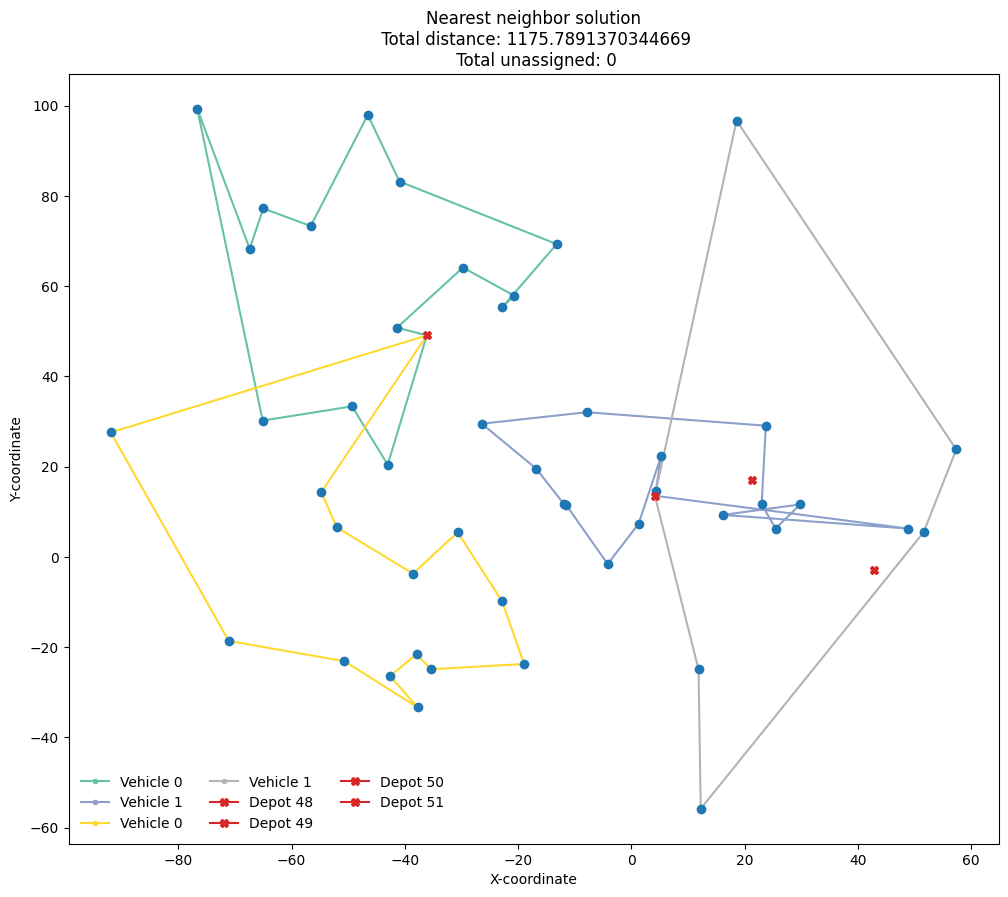

In [11]:
initial_solution = nearest_neighbor_tw()

plot_solution(data, initial_solution, "Nearest neighbor solution")

In [12]:
for route in initial_solution.routes:
    print(route.customers_list)

[51, 16, 1, 14, 28, 4, 20, 33, 29, 8, 5, 13, 18, 26, 23, 51]
[49, 37, 7, 35, 9, 32, 44, 31, 36, 41, 22, 10, 11, 45, 34, 6, 49]
[51, 25, 15, 30, 2, 39, 43, 24, 47, 12, 21, 38, 40, 17, 51]
[49, 42, 46, 3, 27, 19, 49]


In [13]:
late, early, ontime, left_out = verify_time_windows(data, initial_solution)
print(f"Late: {late}, Early: {early}, Ontime: {ontime}")
print(f"Left out customers because of not enough routes/vehicles: {left_out}")

Late: 0, Early: 47, Ontime: 0
Left out customers because of not enough routes/vehicles: 1


## Heuristic solution

Let's now construct our ALNS heuristic. Since we only have one destroy and repair operator, we do not actually use any adaptive operator selection -- but you can easily add more destroy and repair r_operators. 

In [14]:
# alns = ALNS(rnd.default_rng(SEED))
alns = ALNS(rnd.default_rng())

alns.add_destroy_operator(random_removal)
alns.add_destroy_operator(random_route_removal)
alns.add_destroy_operator(cost_reducing_removal)
alns.add_destroy_operator(worst_removal)
# alns.add_destroy_operator(exchange_reducing_removal)  #to be implemented
# alns.add_destroy_operator(shaw_removal)   #to be implemented

alns.add_repair_operator(greedy_repair)
alns.add_repair_operator(wang_greedy_repair)

DEBUG:alns.ALNS:Adding destroy operator random_removal.
DEBUG:alns.ALNS:Adding destroy operator random_route_removal.
DEBUG:alns.ALNS:Adding destroy operator cost_reducing_removal.
DEBUG:alns.ALNS:Adding destroy operator worst_removal.
DEBUG:alns.ALNS:Adding repair operator greedy_repair.
DEBUG:alns.ALNS:Adding repair operator wang_greedy_repair.


In [15]:
num_iterations = 600
init = nearest_neighbor_tw()
# select = AlphaUCB([25, 5, 1, 0], 0.1, 4, 2)
select = RouletteWheel([25, 5, 1, 0], 0.8, 4, 2)
# select = RandomSelect(num_destroy=4, num_repair=2)
accept = RecordToRecordTravel.autofit(
    init.objective(), 0.02, 0, num_iterations
)
stop = MaxIterations(num_iterations)
result, destruction_counts, insertion_counts, d_operators_log, r_operators_log = alns.iterate(init, select, accept, stop, data=data, save_plots=False)

INFO:alns.accept.RecordToRecordTravel:Autofit linear RRT: start_threshold 23.52, end_threshold 0.00, step 0.04.
DEBUG:alns.ALNS:Initial solution has objective 1175.79.
INFO:alns.ALNS:New best with objective 1172.74.
INFO:alns.ALNS:New best with objective 1149.99.
INFO:alns.ALNS:New best with objective 1123.45.
INFO:alns.ALNS:New best with objective 1104.06.
INFO:alns.ALNS:New best with objective 1080.88.
INFO:alns.ALNS:New best with objective 1044.16.
INFO:alns.ALNS:New best with objective 1037.54.
INFO:alns.ALNS:New best with objective 1028.58.
INFO:alns.ALNS:New best with objective 1005.28.
INFO:alns.ALNS:New best with objective 999.51.
INFO:alns.ALNS:New best with objective 994.51.
INFO:alns.ALNS:New best with objective 990.10.


Vehicles left: 2


INFO:alns.ALNS:New best with objective 976.86.
INFO:alns.ALNS:New best with objective 932.26.
INFO:alns.ALNS:New best with objective 907.46.
INFO:alns.ALNS:New best with objective 896.66.
INFO:alns.ALNS:New best with objective 889.26.
INFO:alns.ALNS:New best with objective 882.54.
INFO:alns.ALNS:New best with objective 878.63.
INFO:alns.ALNS:New best with objective 876.70.
INFO:alns.ALNS:New best with objective 875.70.
INFO:alns.ALNS:New best with objective 873.39.
INFO:alns.ALNS:New best with objective 867.69.
INFO:alns.ALNS:Finished iterating in 2.11s.


In [16]:
d_operators = tuple([op[0] for op in alns.destroy_operators])
print(d_operators)
d_ops_dict = {i: op for i, op in enumerate(d_operators)}

('random_removal', 'random_route_removal', 'cost_reducing_removal', 'worst_removal')


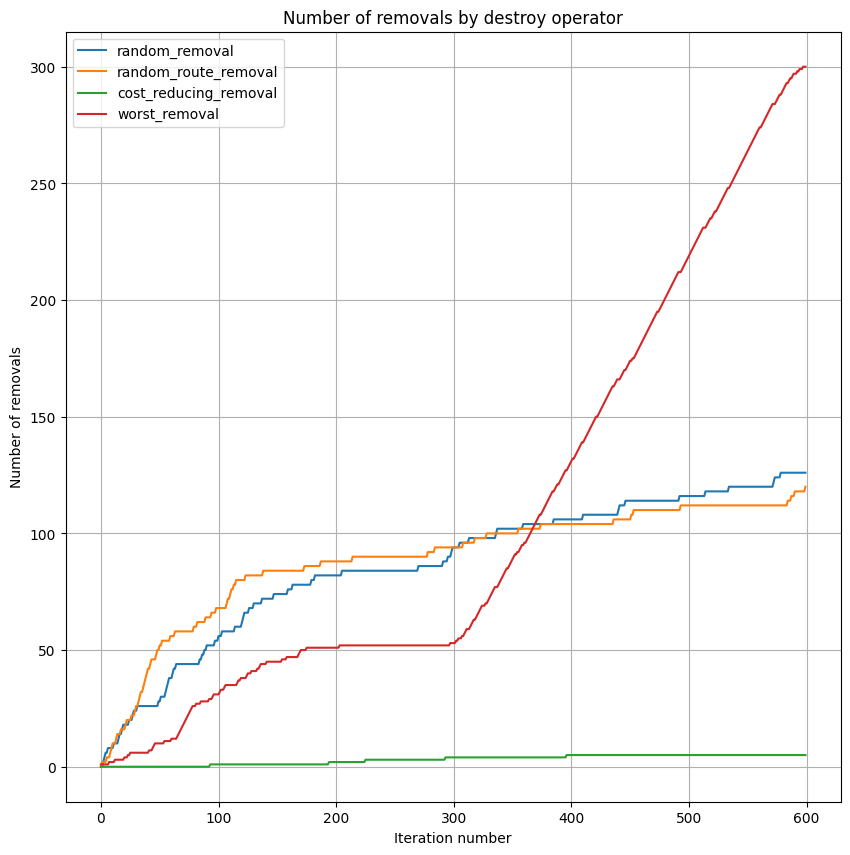

In [17]:
cumulative_sums = np.cumsum(destruction_counts, axis=0)  # Plot each column
rows = np.arange(destruction_counts.shape[0])
fig, ax = plt.subplots(figsize=(10,10))
for col_idx in range(destruction_counts.shape[1]-1):
    plt.plot(rows, cumulative_sums[:, col_idx], label=f"{d_operators[col_idx]}")

# Customize plot
plt.xlabel("Iteration number")
plt.ylabel("Number of removals")
plt.title("Number of removals by destroy operator")
plt.legend()
plt.grid(True)
plt.show()

('greedy_repair', 'wang_greedy_repair')


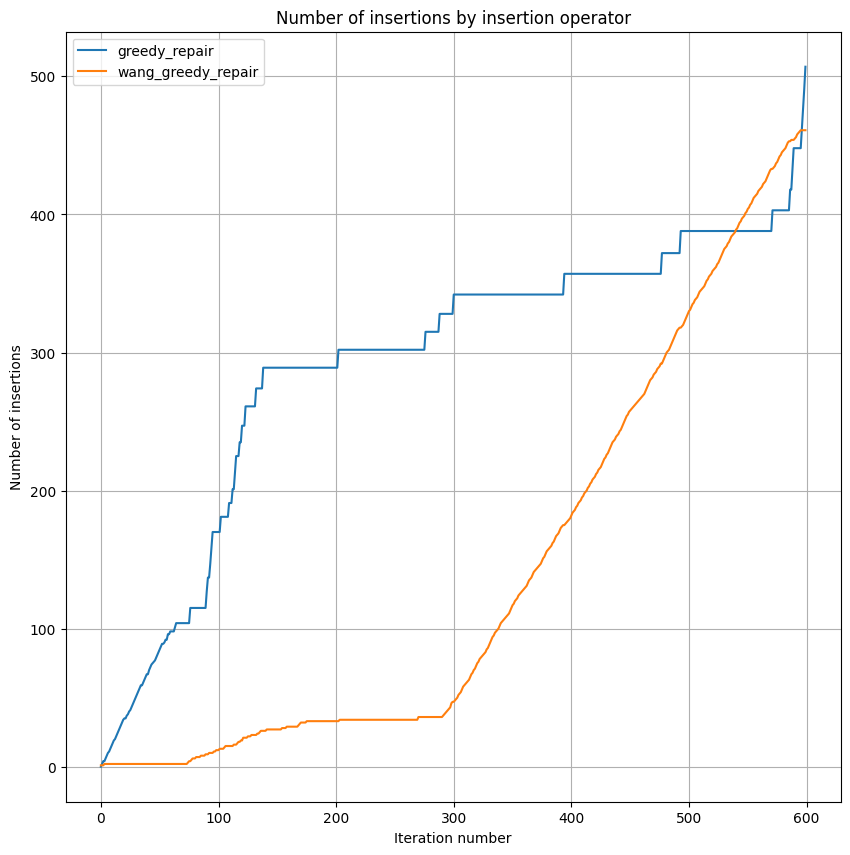

In [18]:
r_operators = tuple([op[0] for op in alns.repair_operators])
r_ops_dict = {i: op for i, op in enumerate(r_operators)}
print(r_operators)
cumulative_sums = np.cumsum(insertion_counts, axis=0)  # Plot each column
rows = np.arange(insertion_counts.shape[0])
fig, ax = plt.subplots(figsize=(10, 10))
for col_idx in range(insertion_counts.shape[1] - 1):
    plt.plot(rows, cumulative_sums[:, col_idx], label=f"{r_operators[col_idx]}")

# Customize plot
plt.xlabel("Iteration number")
plt.ylabel("Number of insertions")
plt.title("Number of insertions by insertion operator")
plt.legend()
plt.grid(True)
plt.show()

## Plotting the destroy and repair operators applications

In [19]:
destroy_operators_log_array = np.zeros(shape=(len(d_operators_log), len(d_operators)), dtype=int)
for i, op in enumerate(d_operators_log):
    destroy_operators_log_array[i, op] +=1
destroy_operators_log_array = np.cumsum(destroy_operators_log_array, axis=0)

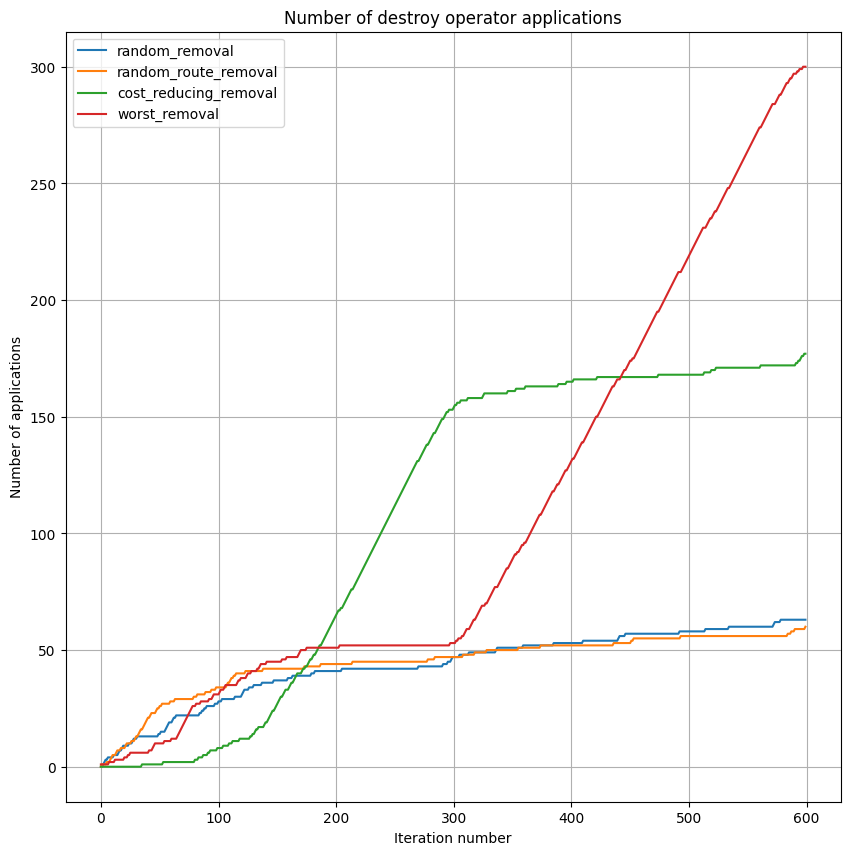

In [20]:
rows = np.arange(destroy_operators_log_array.shape[0])
fig, ax = plt.subplots(figsize=(10, 10))
for col_idx in range(destroy_operators_log_array.shape[1]):
    plt.plot(
        rows, destroy_operators_log_array[:, col_idx], label=f"{d_operators[col_idx]}"
    )

# Customize plot
plt.xlabel("Iteration number")
plt.ylabel("Number of applications")
plt.title("Number of destroy operator applications")
plt.legend()
plt.grid(True)
plt.show()

/tmp/ipykernel_98931/518890836.py:8: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


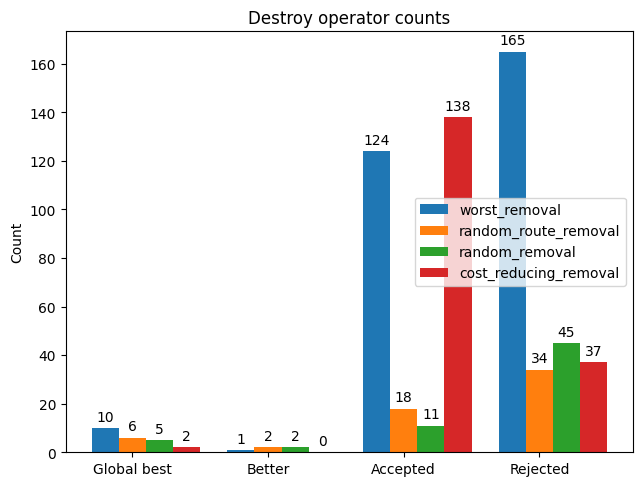

In [21]:
results_df = pd.DataFrame(result.statistics.destroy_operator_counts)
reasons = ["Global best", "Better", "Accepted" , "Rejected"]
x = np.arange(len(reasons))
width = 0.20
multiplier = 0

fig, ax = plt.subplots(layout='constrained')
fig.tight_layout()
for attribute, measurement in results_df.items():
    offset = width*multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

ax.set_ylabel('Count')
ax.set_title('Destroy operator counts')
ax.set_xticks(x + width, reasons)
ax.legend(loc='right', ncols=1)
# ax.set_xlim(0, 4)

plt.show()

In [22]:
repair_operators_log_array = np.zeros(
    shape=(len(r_operators_log), len(r_operators)), dtype=int
)
for i, op in enumerate(r_operators_log):
    repair_operators_log_array[i, op] += 1
repair_operators_log_array = np.cumsum(repair_operators_log_array, axis=0)

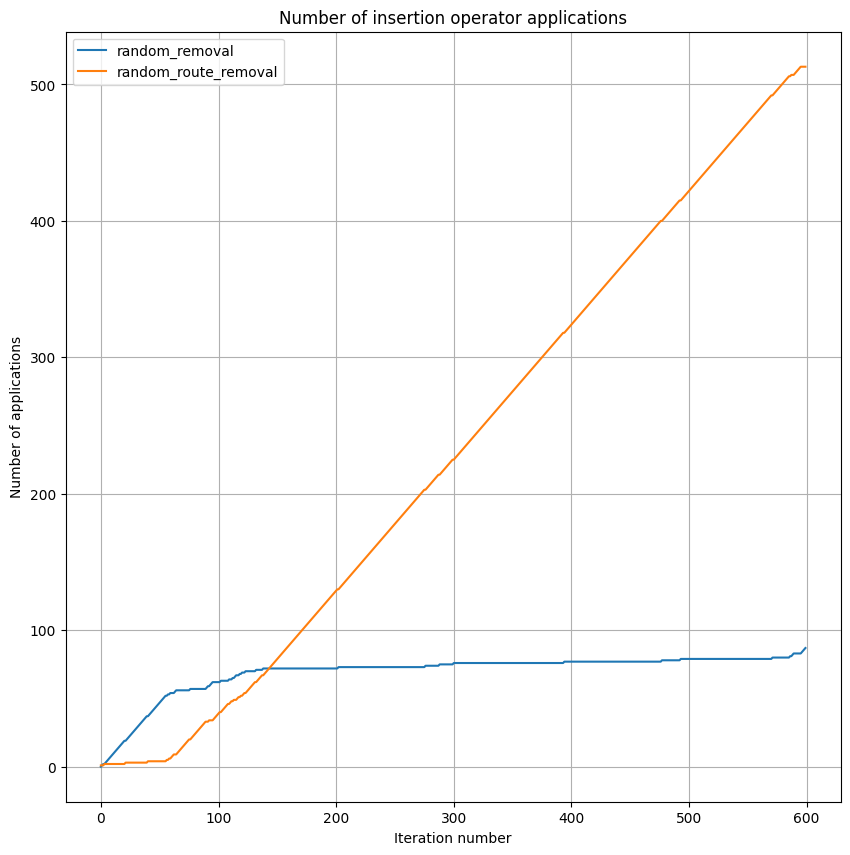

In [23]:
rows = np.arange(repair_operators_log_array.shape[0])
fig, ax = plt.subplots(figsize=(10, 10))
for col_idx in range(repair_operators_log_array.shape[1]):
    plt.plot(
        rows, repair_operators_log_array[:, col_idx], label=f"{d_operators[col_idx]}"
    )

# Customize plot
plt.xlabel("Iteration number")
plt.ylabel("Number of applications")
plt.title("Number of insertion operator applications")
plt.legend()
plt.grid(True)
plt.show()

   wang_greedy_repair  greedy_repair
0                  11             12
1                   1              4
2                 255             36
3                 246             35


(0.0, 4.0)

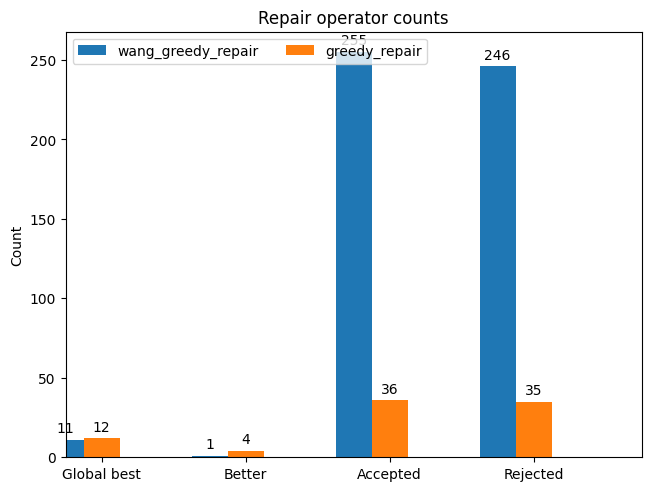

In [24]:
results_df = pd.DataFrame(result.statistics.repair_operator_counts)
print(results_df)

reasons = ["Global best", "Better", "Accepted", "Rejected"]
x = np.arange(len(reasons))
width = 0.25
multiplier = 0

fig, ax = plt.subplots(layout="constrained")

for attribute, measurement in results_df.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

ax.set_ylabel("Count")
ax.set_title("Repair operator counts")
ax.set_xticks(x + width, reasons)
ax.legend(loc="upper left", ncols=4)
ax.set_xlim(0, 4)

## Overall results

In [25]:
solution = result.best_state
objective = solution.objective()
print(f"Best heuristic objective is {objective}.")

Best heuristic objective is 867.6917382783347.


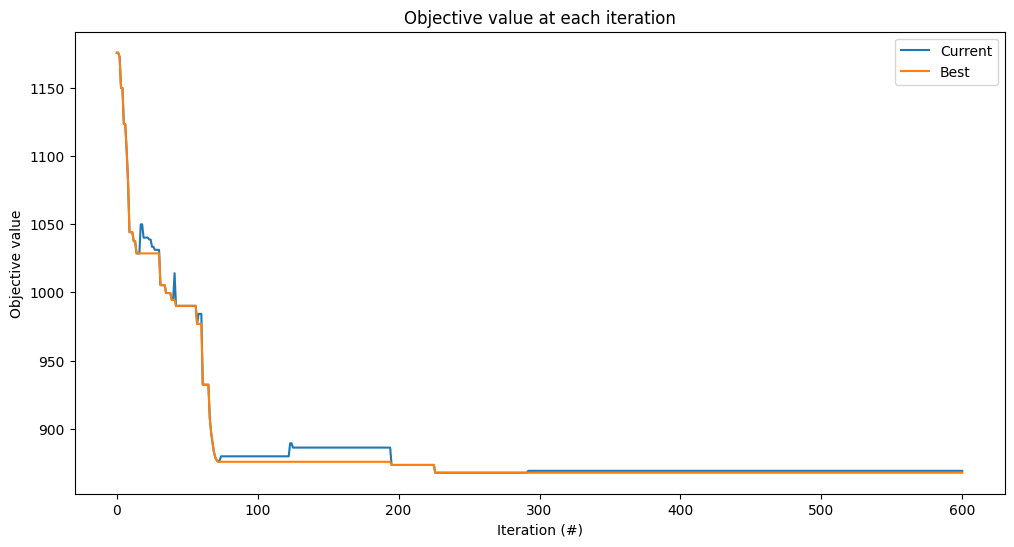

In [26]:
_, ax = plt.subplots(figsize=(12, 6))
result.plot_objectives(ax=ax)

In [27]:
plot_solution(data, initial_solution, "Nearest-neighbor-solution", save=True, figsize=(8, 8))
plot_solution(data, solution, "Heuristic-solution", idx_annotations=False, save=True, figsize=(8, 8))

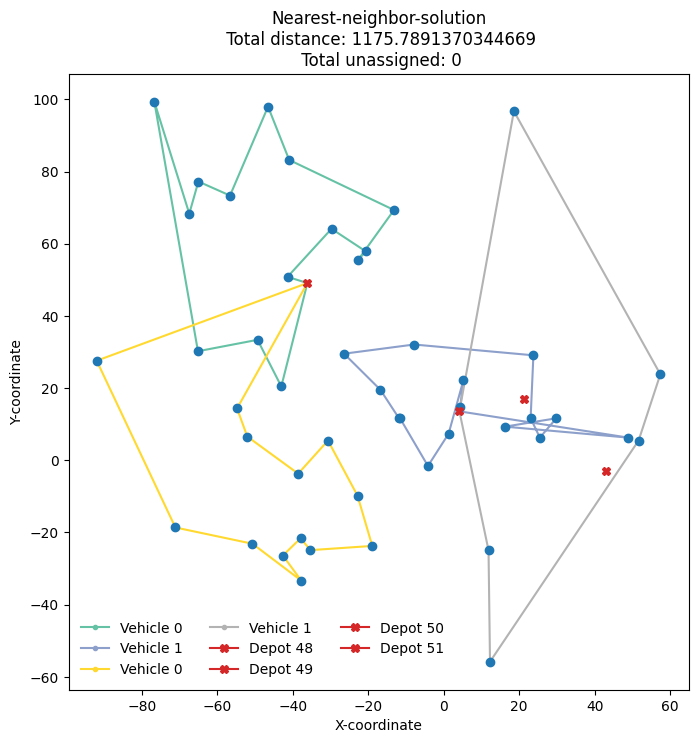

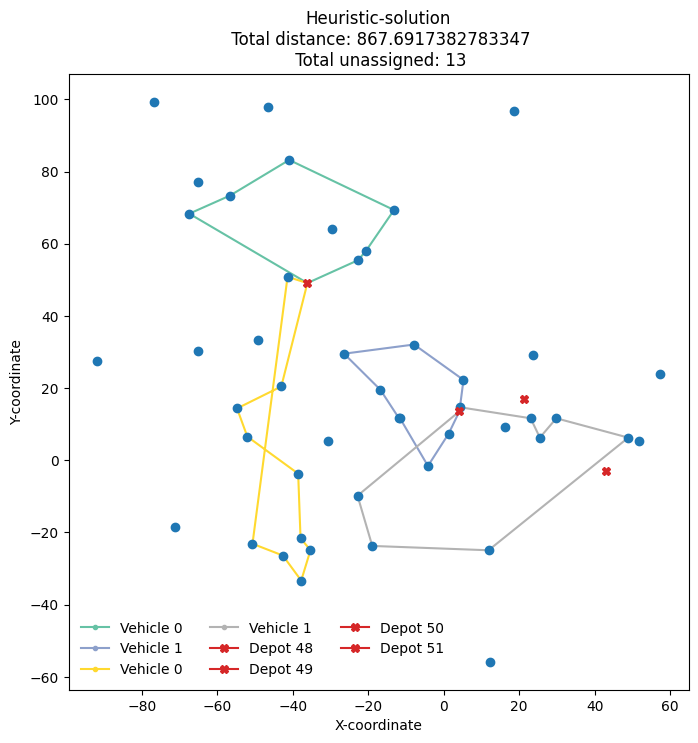

In [28]:
plot_solution(data, initial_solution, "Nearest-neighbor-solution", save=False, figsize=(8, 8))
plot_solution(data, solution, "Heuristic-solution", idx_annotations=False, save=False, figsize=(8, 8))

In [29]:
print(f"There are {len(initial_solution.routes)} routes")
served_customers = 0
for route in initial_solution.routes:
    customers = [cust for cust in route.customers_list if cust not in data["depots"]]
    served_customers += len(customers)
    print(route.customers_list)

print(f"Total number of served customers: {served_customers}")

There are 4 routes
[51, 16, 1, 14, 28, 4, 20, 33, 29, 8, 5, 13, 18, 26, 23, 51]
[49, 37, 7, 35, 9, 32, 44, 31, 36, 41, 22, 10, 11, 45, 34, 6, 49]
[51, 25, 15, 30, 2, 39, 43, 24, 47, 12, 21, 38, 40, 17, 51]
[49, 42, 46, 3, 27, 19, 49]
Total number of served customers: 47


In [30]:
print(f"There are {len(solution.routes)} routes")
served_customers = 0
for route in solution.routes:
    customers = [cust for cust in route.customers_list if cust not in data['depots']]
    served_customers += len(customers)
    print(route.customers_list)


print(f"Total number of served customers: {served_customers}")

There are 4 routes
[51, 28, 14, 4, 20, 29, 5, 51]
[49, 35, 9, 32, 44, 31, 36, 41, 7, 49]
[51, 23, 25, 15, 30, 47, 24, 21, 12, 38, 16, 51]
[49, 39, 43, 42, 6, 45, 11, 10, 37, 49]
Total number of served customers: 32


### Solution

In [31]:
def read_solution_format(file: str, print_data: bool = False) -> dict:
    """
    Read a solution file with the described format.

    Args:
        file (str): Path to the file to be read.
        print_data (bool): If True, print parsed data.

    Returns:
        dict: Parsed data structured as a dictionary.
    """
    with open(file, "r") as f:
        lines = f.readlines()

    # First line contains the cost of the solution
    solution_cost = float(lines[0].strip())

    # Parse the remaining lines for route details
    routes = []
    for line in lines[1:]:
        parts = line.split()
        if len(parts) < 4:
            continue  # Skip malformed lines

        # Extract route details
        day = int(parts[0])
        vehicle = int(parts[1])
        duration = float(parts[2])
        load = float(parts[3])
        # Extract the sequence of customers
        customers = []
        start_times = []
        for segment in parts[4:]:
            if "(" not in segment and ")" not in segment:
                customers.append(int(segment))
            if "(" in segment and ")" in segment:
                _, start_time = segment.split("(")
                start_time = float(start_time.strip(")"))
                start_times.append(start_time)

        # Append route information to the list
        routes.append(
            {
                "day": day,
                "vehicle": vehicle,
                "duration": duration,
                "load": load,
                "customers": customers,
                "star_times": start_times,
            }
        )

    # Compile all data into a dictionary
    data = {"solution_cost": solution_cost, "routes": routes, "n_vehicles": len(routes)}

    if print_data:
        print("Solution Cost:", solution_cost)
        for route in routes:
            print(f"Day {route['day']}, Vehicle {route['vehicle']}:")
            print(f"  Duration: {route['duration']}, Load: {route['load']}")
            print(f"  Customers: {route['customers']}")

    return data


# Example usage
# data = read_solution_format("path_to_file.txt", print_data=True)


bks = read_solution_format("./data/c-mdvrptw-sol/pr01.res", print_data=False)

In [32]:
print(bks.keys())
print(len(bks['routes']))

for route in bks["routes"]:
    print(route["customers"])

dict_keys(['solution_cost', 'routes', 'n_vehicles'])
8
[49, 9, 42, 46, 39, 15, 25, 26, 23, 36, 32, 49]
[49, 35, 44, 31, 41, 7, 37, 49]
[50, 34, 10, 45, 6, 27, 3, 48, 11, 50]
[50, 22, 50]
[51, 28, 4, 19, 14, 1, 16, 51]
[51, 13, 33, 20, 29, 8, 5, 17, 18, 51]
[52, 30, 52]
[52, 2, 47, 24, 12, 38, 40, 21, 43, 52]


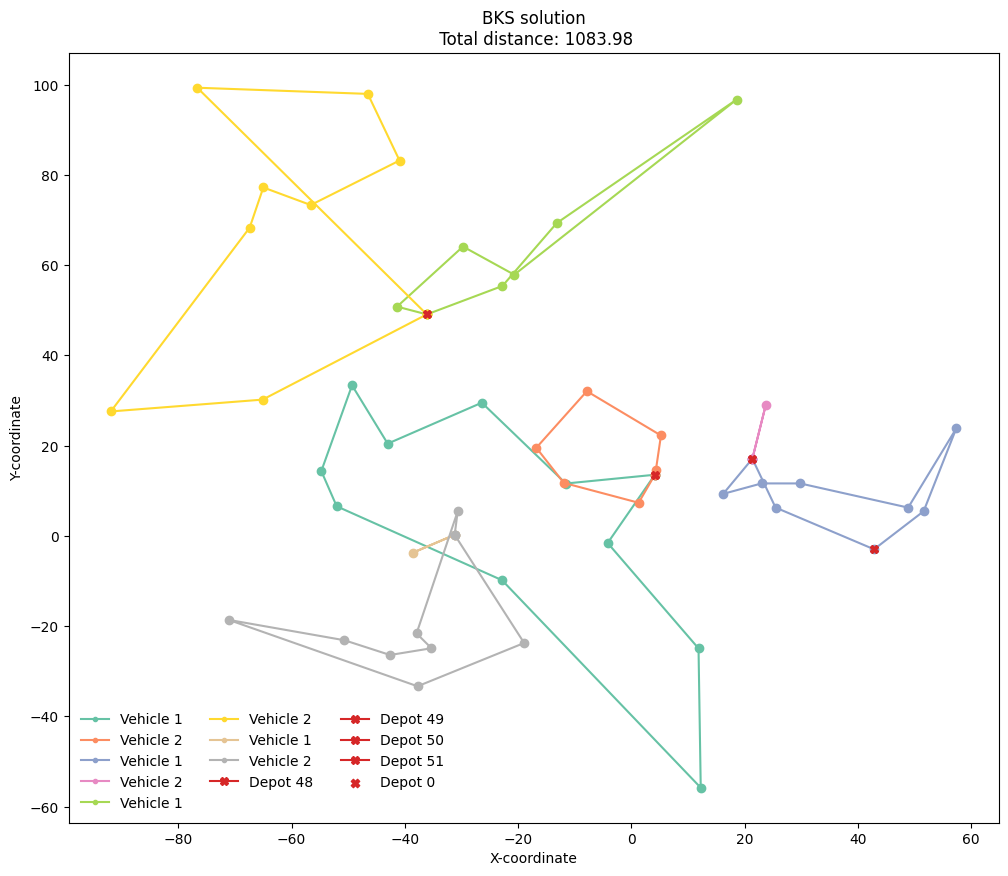

In [33]:
def plot_bks(data: dict, solution, name= "BKS", figsize=(12, 10), save=False):

    fig, ax = plt.subplots(figsize=figsize)
    cmap = plt.get_cmap("Set2", solution["n_vehicles"])
    cmap

    for idx, route in enumerate(solution["routes"]):
        ax.plot(
            [data["node_coord"][loc][0] for loc in route["customers"]],
            [data["node_coord"][loc][1] for loc in route["customers"]],
            color=cmap(idx),
            marker=".",
            label=f"Vehicle {route['vehicle']}",
        )
        for cust in route["customers"]:
            coords = data["node_coord"][cust]
            ax.plot(coords[0], coords[1], "o", c=cmap(idx))

    kwargs = dict(zorder=3, marker="X")

    for i in range(data["dimension"], data["dimension"] + data["n_depots"]):
        depot = data["node_coord"][i]
        ax.plot(depot[0], depot[1], c="tab:red", **kwargs, label=f"Depot {i}")

    ax.scatter(*data["node_coord"][0], c="tab:red", label="Depot 0", **kwargs)

    ax.set_title(f"{name}\n Total distance: {solution["solution_cost"]}")
    ax.set_xlabel("X-coordinate")
    ax.set_ylabel("Y-coordinate")
    ax.legend(frameon=False, ncol=3)

    if save:
        plt.savefig(f"./plots/{name}.png")
        plt.close()

plot_bks(data, bks, "BKS solution",)

In [34]:
print(f"data['node_coord][0]: {data['node_coord'][0]}")

data['node_coord][0]: [None None]
